In [1]:
import json_lines
from langdetect import detect
from langdetect import detect_langs
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.neural_network import MLPClassifier
import numpy as np
import threading
import time

from sklearn.datasets import load_iris
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import pandas as pd
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

ALL_TAGS= ['CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNS', 'NNP', 'NNPS', 'PDT',
 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP',
 'WP$', 'WRB']
ACCEPTABLE_TAGS= ['CC', 'DT', 'EX', 'FW', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'PDT',
 'POS', 'PRP', 'PRP$', 'RP', 'TO', 'UH', 'VBD', 'VBG', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB']

MAX_FEATURES= 100 # incrasing this grants marginal increases in accuracy at the cost of run time
MIN_ENGLISH= 0.9999
LIMIT_INPUT_ROWS= 300 # less then ~1,500 means you get a biased dataset, because for some reason the first load of reviews are all positive
K_FOLDS= 5


In [2]:
# READ IN INFO
reviews= []; polarity= []; are_early= []
with open ('reviews.json', 'rb') as f:
    i= 0
    for item in json_lines.reader(f):
        if i < LIMIT_INPUT_ROWS:
            try:
                langs = detect_langs(item['text'])
            except:
                pass
            for lang in langs:
                if str(lang)[0:2] == 'en':
                    if float(str(lang)[3:]) > MIN_ENGLISH:
                        reviews.append(item['text'])
                        polarity.append(item['voted_up'])
                        are_early.append(item['early_access'])
                        i+= 1
                        break
        else:
            break

# END PRODUCTS: reviews, polarity, are_early

In [3]:
# FILTER TEXT
print(reviews)
filtered_reviews= []
for text in reviews:
    new_text= []
    tags= nltk.pos_tag(text)
    for j, word in enumerate(text.split()):
        if tags[j][1] in ACCEPTABLE_TAGS:
            new_text.append(word)
    filtered_reviews.append(new_text)
    #print(tags)
reviews= [' '.join([str(elem) for elem in sublist]) for sublist in filtered_reviews]
print("###################")
print(reviews)
# END PRODUCTS: reviews (as a list of list! rather than a list or strings)

["neat little game. play if your staple fps game's server is down or sth. maps and weapon distribution system needs rework.", "Kinda decent f2p mmorpg that has no class limitations(hooray!)(and that game where i drained too much hours...) Community: In PvE, you may encounter friendly ppl(i managed to even encounter person that i love :o), while in PvP mostly complainers(those who complain about AT&T releasing too much of 1st in battle xD) or persons that make you turn into complainer.(As always!) Main review part: Graphics: Everything looks kinda pretty, but performance is not what expected for java and openGL...(8/10) Gameplay: SK features huge choice of equipment, which adds variety to the gear and gameplay itself(like you can use guns, or bombs, or swords.. or 2 of those... or all 3 xD) But because this game features grinding in big quantities you  may get bored(or may not if you do co-op with your friend(s))(8/10) Controls: In order to rekt m8s you need to change much(like binding 

###################
['little game. or sth. distribution system rework.', "decent that has game drained managed to person that i :o), PvP mostly complainers(those who 1st or make into complainer.(As Graphics: but performance what expected variety the and or of game in may if Controls: rekt change binding weps supposed but to be interesting new 'n Late game you to get Overall game you for ya... game doesn't cost it updated reduced.", 'buggy that be Optimize or Perfect music Reality <3', 'â™¥â™¥â™¥â™¥â™¥â™¥â™¥ good', "have champions, units fight by side. The to guide victory. By dropping you want your situation doesn't to dropping your time team, that everything a mystical little because like also has is F2P. There that units because it try!", "I this a didn't me balanced I think.", 'ItÂ´s great deserved spiritual Wars, with which makes funn unit pixel My so often, at a pc guess) itÂ´s not I recomend who', 'Ð¥Ð¾Ñ€Ð¾ÑˆÐ°Ñ\x8f', 'BUT play', 'with the share the then the your by dozens if of 

In [4]:
# MOST FREQ WORDS AS FEATURES
word_counts = {}
for text in reviews:
    for word in text.split():
        if word in word_counts:
            word_counts[word]+= 1
        else:
            word_counts[word]= 1
word_counts= {k: v for k, v in sorted(word_counts.items(), key=lambda item: item[1], reverse=True)}
trimd_word_counts= {}
for i, entry in enumerate(word_counts):
    if i >= MAX_FEATURES:
        break
    trimd_word_counts[entry]= word_counts[entry]

# END PRODUCTS: trimd_word_counts

In [5]:
# CREATE 1-HOT ENCODINGS
amount_features= MAX_FEATURES
one_hots= []
for text in reviews:
    one_hot= []
    for i in range(MAX_FEATURES):
        one_hot.append(0)
    for word in text.split():
        if word in trimd_word_counts:
            one_hot[list(trimd_word_counts).index(word)]+= 1
    one_hots.append(one_hot)

for i, one_hot in enumerate(one_hots): # convert array of lists into 2d array
    one_hot_arr = np.array(one_hot)
    one_hots[i] = one_hot_arr
    print(one_hot)

x= np.array(one_hots)
y= np.array(polarity, dtype=np.int)

# END PRODUCTS: x, y

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
[1, 3, 1, 0, 1, 0, 2, 5, 0, 0, 2, 1, 1, 0, 1, 0, 2, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

5.0


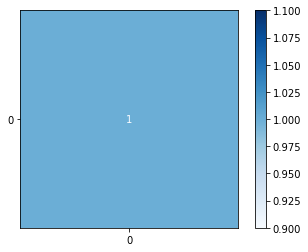

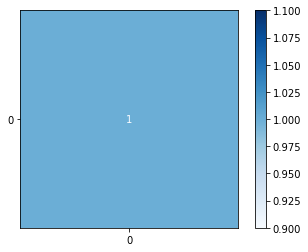

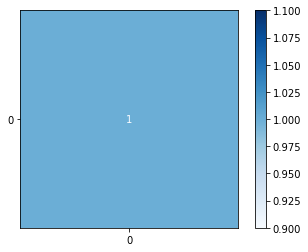

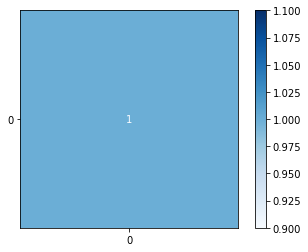

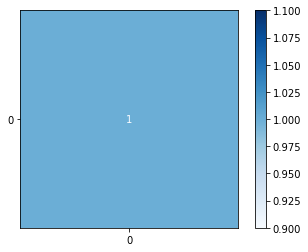

In [6]:
# SPLIT, TRAIN, PREDICT, GRAPH
total_score= 0
kfold= KFold(K_FOLDS, shuffle=True, random_state=1)
for train_index1, test_index1 in kfold.split(x):
    x_trains= []
    x_tests= []
    y_trains= []
    y_tests= []
    sub_x= []
    sub_y= []
    for index in test_index1:
        x_tests.append(x[index])
        y_tests.append(y[index])
    for index in train_index1:
        sub_x.append(x[index])
        sub_y.append(y[index])
    kfold= KFold(K_FOLDS - 1, shuffle=True, random_state=1)
    for train_index2, test_index2 in kfold.split(sub_x):
        x_train= []
        y_train= []
        for index in train_index2:
            x_train.append(sub_x[index])
            y_train.append(sub_y[index])
        x_trains+= x_train
        y_trains+= y_train
    clf= MLPClassifier(hidden_layer_sizes=(amount_features, int(amount_features/2), int(amount_features/4)), activation="relu", solver="adam", random_state=1).fit(x_trains, y_trains)
    y_preds= clf.predict(x_tests)
    total_score+= clf.score(x_tests, y_tests)
    try:
        #print("overall accuracy: ", clf.score(x_tests, y_tests))
        fig= plot_confusion_matrix(clf, x_tests, y_tests, display_labels=["voted down", "voted up"], cmap=plt.cm.Blues, normalize="all")
    except ValueError:
        pass
print(total_score / K_FOLDS)